<a target="_blank" href="https://colab.research.google.com/github/AndreasMarken/blockchain-project/blob/master/main.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Project on Anti-money laundering (AML) in the course Blockchain and Cryptocurrencies

*Made by Andreas Ahlgren Marken and Per Martin Herdlevær.*

Having read and analysed different previous projects and papers. We gained a lot of insight in techniques and methods on how to adress AML. We sought to explore the effectiveness of various machine learning techniques in transaction classification and visualise this. Previous studies have extensively utilized traditional machine learning models such as GNNs and random forest, but we wanted to use several techniques to highlight what what works best, when and why.


Previous projects often focused on either feature-rich tabular datasets or emphasized the power of graph representation. We wanted to build on these works to not only benchmark the performance of traditional models against graph neural networks but also understand the circumstances under which graph-based learning provides a significant advantage. By leveraging the Elliptic Bitcoin Dataset we aimed to evaluate these methods in a real-world scenario and identify why certain techniques excel over others.


Note: We reccomend that you run this in google Colab, with access to GPUs, this makes the process of training and running the GNNs, a lot faster. Verify that you have a gpu available:

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


For this project, we will need the python package torch-geometric to use pytorch GNNs. Hence, we start of by installing the required package.

In [ ]:
!pip install -q torch_geometric

We will also use Deep Neural Decision Forests, thus, we also download this package.

In [ ]:
!pip install -q tensorflow-decision-forests

We also import all neccessary packages for this project.

In [ ]:
import os
import numpy as np
import pandas as pd

import torch
import torch_geometric

import matplotlib.pyplot as plt
import networkx as nx
import torch.nn.functional as F

from xgboost import XGBClassifier

from torch_geometric.utils import from_networkx

from torch_geometric.nn import GCNConv
from torch_geometric.nn import GINConv, Sequential

from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier

import ydf

import kagglehub

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Torch version:", torch.__version__)
print("Torch Geometric version:", torch_geometric.__version__)

Torch version: 2.5.1+cu121
Torch Geometric version: 2.6.1


# Dataset

Next up, we download the [Elliptic](https://www.kaggle.com/datasets/ellipticco/elliptic-data-set/data) dataset from kaggle.

The Elliptic dataset is a Bitcoin transaction graph containing 203,769 nodes (transactions) and 234,355 edges (flows of Bitcoin between transactions). Each node is labeled as licit, illicit, or unknown, with 166 associated features. These features are divided into 94 transaction-specific attributes (e.g., number of inputs/outputs, transaction fee, output volume) and 72 aggregated features, summarizing one-hop neighbor statistics (e.g., averages, standard deviations). The dataset spans 49 time steps, representing transactions broadcasted within a few hours, making it a valuable resource for analyzing temporal and relational patterns in blockchain-based financial activities.

In [ ]:
path = kagglehub.dataset_download("ellipticco/elliptic-data-set")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/ellipticco/elliptic-data-set/versions/1


We now need the download paths for the different files in the dataset. We therefore print these so that we can import them as dataframes.

In [ ]:
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/root/.cache/kagglehub/datasets/ellipticco/elliptic-data-set/versions/1/elliptic_bitcoin_dataset/elliptic_txs_features.csv
/root/.cache/kagglehub/datasets/ellipticco/elliptic-data-set/versions/1/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv
/root/.cache/kagglehub/datasets/ellipticco/elliptic-data-set/versions/1/elliptic_bitcoin_dataset/elliptic_txs_classes.csv


# Data import and processing

We start off by importing the csv files to pandas DataFrames. Here we have three different dataframes. The first one, features, is the transaction file containing a list of all the transactions and its beloning features.

The classes dataframe contains the classification of the transactions in the features dataframe. Classifying each transaction as either licit, illicit or unknown.

The third dataframe, the edgelist, contains information in order to create graphs to be used in GNNs. These contain the information about the bitcoin flow in the transactions.

In [ ]:
elliptic_txs_features = pd.read_csv("/root/.cache/kagglehub/datasets/ellipticco/elliptic-data-set/versions/1/elliptic_bitcoin_dataset/elliptic_txs_features.csv", header=None)
elliptic_txs_classes = pd.read_csv("/root/.cache/kagglehub/datasets/ellipticco/elliptic-data-set/versions/1/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
elliptic_txs_edgelist = pd.read_csv("/root/.cache/kagglehub/datasets/ellipticco/elliptic-data-set/versions/1/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")

## Insepcting the data
Next up, we can choose to inspect the dataset to get a grasp of its features.

In [ ]:
elliptic_txs_features.head()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [ ]:
elliptic_txs_classes.head()

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown
3,232438397,2
4,230460314,unknown


In [ ]:
elliptic_txs_edgelist.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


## Preprocessing



We start of by renaming the columns in the dataset in order to get a better visualisation of the dataset.

In [ ]:
elliptic_txs_features.columns = ['txId'] + [f'V{i}' for i in range(1, 167)]
elliptic_txs_features.head()

,txId,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


Secondly we move on to combining the *classes* and *features* dataset, in order to get a dataset full with predicting capabilities.

In [ ]:
data = pd.merge(elliptic_txs_classes, elliptic_txs_features, on="txId", how="left")
data.head()

,txId,class,V1,V2,V3,V4,V5,V6,V7,V8,...,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166
0,230425980,unknown,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,unknown,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,unknown,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,2,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,unknown,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


Next up we filter out unlabeled data. To build a model capable of predicting unknown values, it's essential to ensure that the dataset is free of unlabeled data. Consequently, we begin by filtering out all entries labeled as `unknown`. This step ensures a clean and usable dataset for training the model.

In [ ]:
data = data[data['class'].isin(["1", "2"])]
data.head()

,txId,class,V1,V2,V3,V4,V5,V6,V7,V8,...,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166
3,232438397,2,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
9,232029206,2,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,...,-0.577099,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792
10,232344069,2,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
11,27553029,2,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.539735,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
16,3881097,2,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,...,-0.577099,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984


For more ease of use in the classifications methods, we map the values from class "2(licit)"->0 and "1(illicit)"->1.

In [ ]:
data['class'] = data['class'].map({'2': 0, '1': 1})
data.head()

,txId,class,V1,V2,V3,V4,V5,V6,V7,V8,...,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166
3,232438397,0,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
9,232029206,0,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,...,-0.577099,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792
10,232344069,0,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
11,27553029,0,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.539735,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
16,3881097,0,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,...,-0.577099,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984


Next up, we perform a scaling process to the dataset. We use the scaler to standardize the feature values so they have a consistent range, typically with a mean of 0 and a standard deviation of 1. This ensures that all features contribute equally, preventing those with larger ranges from dominating the analysis. Standardization also helps improve the overall performance and stability of the model by making the data easier to process and interpret.

In [ ]:
scaler = StandardScaler()
feature_columns = data.columns[2:]  # Exclude txId and class from the features
data[feature_columns] = scaler.fit_transform(data[feature_columns])
data.head()

,txId,class,V1,V2,V3,V4,V5,V6,V7,V8,...,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166
3,232438397,0,-1.556878,0.307025,1.168821,-0.748109,7.643807,-0.053406,6.039024,21.528480,...,-0.570335,-0.619017,0.155526,0.155844,2.115930,0.016322,-0.117599,0.593442,-0.08332,-0.082052
9,232029206,0,-1.556878,0.067780,0.271911,-0.226081,2.628539,-0.053406,2.820415,1.501088,...,-0.570335,-0.619017,0.155526,0.155844,1.200416,-0.028141,-0.117599,0.270020,-0.08332,-0.082052
10,232344069,0,-1.556878,-0.135517,-0.222646,-1.270138,-0.183761,-0.041930,-0.187137,-0.080022,...,-0.570335,-0.619017,0.155526,0.155844,0.056025,-0.083719,-0.117599,-0.134257,-0.08332,-0.082052
11,27553029,0,-1.556878,-0.140505,-0.222646,-1.270138,-0.183761,-0.041930,-0.187137,-0.080022,...,-0.529548,-0.586053,-1.091739,-1.090228,0.056025,-0.083719,-0.117599,-0.134257,-0.08332,-0.082052
16,3881097,0,-1.556878,-0.170324,-0.222646,-1.270138,-0.090018,-0.041930,-0.134373,0.447015,...,-0.570335,-0.605832,0.155526,0.155844,0.056025,-0.072604,-0.091257,-0.093830,-1.72568,-1.726407


Then we finally split the data in to X and y variables that will be used for training. Here we choose a test_size of 20% of the dataset in order to have some data that can be used for predicting.

In [ ]:
X = data.drop(columns=['txId', 'class'])
y = data['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# The models
Here we provide a short description and overview of the models that we will implement to create an overview of the different models.

**Traditional Tree-Based Models: Random Forest and XGBoost**

Tree-based ensemble methods are highly effective for structured tabular datasets. Random Forest builds multiple decision trees and averages their predictions to reduce overfitting and improve accuracy. XGBoost leverages gradient boosting for speed, nonlinear interaction modeling, and robust handling of missing data, often outperforming other models on structured data.

**Hybrid Neural Tree Models: Gradient Boosted Trees (DNDF) and Random Forest Learner (DNDF)**

These models combine decision tree principles with neural network optimization to create differentiable neural decision forests (DNDF). Gradient Boosted Trees merge the strengths of traditional trees with neural optimization, while Random Forest Learner adapts random forest techniques for gradient-based learning, bridging classical and neural approaches.

**Graph-Based Models: Simple GNN, GCN, and GIN**

Graph-based models are designed for relational data, such as transaction networks, by capturing dependencies between nodes and edges. Simple GNNs aggregate information from neighbors for baseline graph learning, GCNs extend this to larger neighborhoods with multi-layer aggregation, and GINs provide maximal expressiveness for topology-critical tasks by distinguishing complex graph structures.

# Random forest
The first model we want to test is Random forest. We start of by initializing the model. Then we fit on the training data before we predict on the test data. We then print the classification report and store the metrics for future use.

In [ ]:
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)
rf_clf.fit(X_train, y_train)

rf_y_pred = rf_clf.predict(X_test)
print("Random Forest Classifier Report:")
print(classification_report(y_test, rf_y_pred))

rf_accuracy = rf_clf.score(X_test, y_test)
rf_f1 = f1_score(y_test, rf_y_pred, average='weighted')

rf_cm = confusion_matrix(y_test, rf_y_pred)

Random Forest Classifier Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8414
           1       1.00      0.89      0.94       899

    accuracy                           0.99      9313
   macro avg       0.99      0.94      0.97      9313
weighted avg       0.99      0.99      0.99      9313



# XGBoost
Next, we move on and test XGBoost, as that model has common capabilities of being able to more accurately predict complex data as well as speeding up inference. We perform the same inference as stated above.

In [ ]:
xgb_clf = XGBClassifier(random_state=42, n_estimators=100, eval_metric='logloss', device="cuda")
xgb_clf.fit(X_train, y_train)

xgb_y_pred = xgb_clf.predict(X_test)
print("XGBoost Classifier Report:")
print(classification_report(y_test, xgb_y_pred))

xgb_accuracy = xgb_clf.score(X_test, y_test)
xgb_f1 = f1_score(y_test, xgb_y_pred, average='weighted')

xgb_cm = confusion_matrix(y_test, xgb_y_pred)

XGBoost Classifier Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      8414
           1       0.99      0.92      0.96       899

    accuracy                           0.99      9313
   macro avg       0.99      0.96      0.98      9313
weighted avg       0.99      0.99      0.99      9313



# Deep Neural Decision Forest

For the next section, we move on to discuss about DNDFs.

## GradientBoostedTreesLearner
The first model we have a look at is the GradientBoostedTreesLearner. We will use the same process as described above for inference and performance calculations.

Note: We made some small changes to how we model our dataset for this model after our presentation, this has led to significantly improved results.

In [ ]:
dndf_model = ydf.GradientBoostedTreesLearner(label="class").train(pd.concat([X_train, y_train], axis=1))

Train model on 37251 examples
Model trained in 0:02:18.255680


We need to perform some intermediate steps to calculate the predicion values. We say that all predictions above 0.5 will be counted as 1.

In [ ]:
dndf_y_pred = dndf_model.predict(pd.concat([X_test, y_test], axis=1))

dndf_y_pred = dndf_y_pred > 0.5
dndf_y_pred = dndf_y_pred.astype(int)
dndf_y_pred = dndf_y_pred.flatten()
dndf_y_pred

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
print("Deep Neural Decision Forest Classifier Report:")
print(classification_report(y_test, dndf_y_pred))

dndf_accuracy = sum(dndf_y_pred == y_test) / len(y_test)
dndf_f1 = f1_score(y_test, dndf_y_pred, average='weighted')
dndf_cm = confusion_matrix(y_test, dndf_y_pred)

Deep Neural Decision Forest Classifier Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      8414
           1       0.99      0.92      0.95       899

    accuracy                           0.99      9313
   macro avg       0.99      0.96      0.97      9313
weighted avg       0.99      0.99      0.99      9313



## Using RandomForestLearner

In [ ]:
rfl_model = ydf.RandomForestLearner(label="class").train(pd.concat([X_train, y_train], axis=1))

rfl_predictions = rfl_model.predict(pd.concat([X_test, y_test], axis=1))

Train model on 37251 examples
Model trained in 0:00:40.450942


In [ ]:
rfl_predictions = rfl_predictions > 0.5
rfl_predictions = rfl_predictions.astype(int)
rfl_predictions = rfl_predictions.flatten()
rfl_predictions

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
print("Random Forest Classifier Report:")
print(classification_report(y_test, rfl_predictions))

rfl_accuracy = sum(rfl_predictions == y_test) / len(y_test)
rfl_f1 = f1_score(y_test, rfl_predictions, average='weighted')

rfl_cm = confusion_matrix(y_test, rfl_predictions)

Random Forest Classifier Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8414
           1       0.99      0.88      0.93       899

    accuracy                           0.99      9313
   macro avg       0.99      0.94      0.96      9313
weighted avg       0.99      0.99      0.99      9313



# Creating a Graph from the Dataset
For this section, we want to create a graph from the data in ``elliptic_txs_edgelist.csv``. We will process each transaction, and add every nodes from the edgelist to the graph.

In [ ]:
graph = nx.from_pandas_edgelist(elliptic_txs_edgelist, source="txId1", target="txId2", create_using=nx.DiGraph())

for _, row in data.iterrows():
    if row['txId'] in graph:
        graph.nodes[row['txId']]['features'] = row.iloc[2:].values
        graph.nodes[row['txId']]['label'] = row['class']

print(f"Graph created with {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges.")

Graph created with 203769 nodes and 234355 edges.


For the next section, we have to remove the nodes that we are unable to predict because of its lack of a label. For thoose missing the features variables, we create a standard default features list which contains only 0´s. For this part we also remove the nodes without a label.

In [ ]:
default_features = [0] * 166

nodes_to_remove = []

for node in graph.nodes:
    if 'features' not in graph.nodes[node]:
        graph.nodes[node]['features'] = default_features
    if 'label' not in graph.nodes[node]:
        nodes_to_remove.append(node)

graph.remove_nodes_from(nodes_to_remove)

print(f"Graph after removing nodes with missing features: {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges.")

Graph after removing nodes with missing features: 46564 nodes and 36624 edges.


Next up, we mark mark some of the nodes in the graph as training nodes and some of them for test.

In [ ]:
graph_data = from_networkx(graph)

In [ ]:
graph_data.x = torch.tensor([graph.nodes[node]['features'] for node in graph.nodes], dtype=torch.float)
graph_data.y = torch.tensor([graph.nodes[node]['label'] for node in graph.nodes], dtype=torch.long)

In [ ]:
# Assuming `graph_data` has `y` (labels) attribute
num_nodes = graph_data.num_nodes

# Split the data into train, validation, and test sets
train_ratio, val_ratio = 0.7, 0.1
num_train = int(num_nodes * train_ratio)
num_val = int(num_nodes * val_ratio)
num_test = num_nodes - num_train - num_val

# Random permutation of indices
perm = torch.randperm(num_nodes)

# Create masks
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[perm[:num_train]] = True
val_mask[perm[num_train:num_train + num_val]] = True
test_mask[perm[num_train + num_val:]] = True

# Assign masks to the graph data
graph_data.train_mask = train_mask
graph_data.val_mask = val_mask
graph_data.test_mask = test_mask

Before we map it do our desired device.

In [ ]:
graph_data = graph_data.to(device)

# Graph Neural Network (GNN)
For the next part, we create a GNN which we can use to perform inference on the dataset.

In [ ]:
class SimpleGNN(torch.nn.Module):
    def __init__(self):
        super(SimpleGNN, self).__init__()
        self.conv1 = GCNConv(graph_data.num_features, 64)
        self.conv2 = GCNConv(64, 2)  # Binary classification

    def forward(self, data):
        x, edge_index = graph_data.x, graph_data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [ ]:
model = SimpleGNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    out = model(graph_data)
    loss = criterion(out[graph_data.train_mask], graph_data.y[graph_data.train_mask])
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")
        model.eval()
        with torch.no_grad():
            pred = model(graph_data).argmax(dim=1)
            train_acc = (pred[graph_data.train_mask] == graph_data.y[graph_data.train_mask]).float().mean()
            val_acc = (pred[graph_data.val_mask] == graph_data.y[graph_data.val_mask]).float().mean()
            test_acc = (pred[graph_data.test_mask] == graph_data.y[graph_data.test_mask]).float().mean()
            print(f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")

print("GNN classification Report:")
print(classification_report(graph_data.y[graph_data.test_mask].cpu().numpy(), pred[graph_data.test_mask].cpu().numpy()))

gnn_accuracy = test_acc.item()
gnn_f1 = f1_score(graph_data.y[graph_data.test_mask].cpu().numpy(), pred[graph_data.test_mask].cpu().numpy(), average='weighted')

gnn_cm = confusion_matrix(graph_data.y[graph_data.test_mask].cpu().numpy(), pred[graph_data.test_mask].cpu().numpy())

Epoch 20, Loss: 0.16608257591724396
Train Acc: 0.9524, Val Acc: 0.9510, Test Acc: 0.9514
Epoch 40, Loss: 0.13007384538650513
Train Acc: 0.9635, Val Acc: 0.9620, Test Acc: 0.9608
Epoch 60, Loss: 0.11472489684820175
Train Acc: 0.9665, Val Acc: 0.9659, Test Acc: 0.9630
Epoch 80, Loss: 0.10532081127166748
Train Acc: 0.9695, Val Acc: 0.9674, Test Acc: 0.9654
Epoch 100, Loss: 0.09777534008026123
Train Acc: 0.9713, Val Acc: 0.9689, Test Acc: 0.9660
Epoch 120, Loss: 0.09130442887544632
Train Acc: 0.9727, Val Acc: 0.9699, Test Acc: 0.9659
Epoch 140, Loss: 0.08590006083250046
Train Acc: 0.9744, Val Acc: 0.9706, Test Acc: 0.9673
Epoch 160, Loss: 0.08111574500799179
Train Acc: 0.9757, Val Acc: 0.9710, Test Acc: 0.9676
Epoch 180, Loss: 0.07679080963134766
Train Acc: 0.9771, Val Acc: 0.9719, Test Acc: 0.9683
Epoch 200, Loss: 0.07286711782217026
Train Acc: 0.9779, Val Acc: 0.9719, Test Acc: 0.9692
GNN classification Report:
              precision    recall  f1-score   support

           0       0.9

# Graph Convolutional Network (GCN)
The next GNN we implement is a GCN which can aggregate information across layers to capture relationships within broader graph neighborhoods.

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(graph_data.num_features, 64)
        self.conv2 = GCNConv(64, 32)
        self.conv3 = GCNConv(32, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

In [ ]:
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    out = model(graph_data)
    loss = criterion(out[graph_data.train_mask], graph_data.y[graph_data.train_mask])
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")
        model.eval()
        with torch.no_grad():
            pred = model(graph_data).argmax(dim=1)
            train_acc = (pred[graph_data.train_mask] == graph_data.y[graph_data.train_mask]).float().mean()
            val_acc = (pred[graph_data.val_mask] == graph_data.y[graph_data.val_mask]).float().mean()
            test_acc = (pred[graph_data.test_mask] == graph_data.y[graph_data.test_mask]).float().mean()
            print(f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")

print("GCN classification Report:")
print(classification_report(graph_data.y[graph_data.test_mask].cpu().numpy(), pred[graph_data.test_mask].cpu().numpy()))

gcn_accuracy = test_acc.item()
gcn_f1 = f1_score(graph_data.y[graph_data.test_mask].cpu().numpy(), pred[graph_data.test_mask].cpu().numpy(), average='weighted')

gcn_cm = confusion_matrix(graph_data.y[graph_data.test_mask].cpu().numpy(), pred[graph_data.test_mask].cpu().numpy())

Epoch 20, Loss: 0.20012347400188446
Train Acc: 0.9433, Val Acc: 0.9448, Test Acc: 0.9402
Epoch 40, Loss: 0.15991996228694916
Train Acc: 0.9522, Val Acc: 0.9517, Test Acc: 0.9514
Epoch 60, Loss: 0.14025552570819855
Train Acc: 0.9622, Val Acc: 0.9628, Test Acc: 0.9611
Epoch 80, Loss: 0.12765365839004517
Train Acc: 0.9667, Val Acc: 0.9667, Test Acc: 0.9645
Epoch 100, Loss: 0.11829090863466263
Train Acc: 0.9684, Val Acc: 0.9689, Test Acc: 0.9658
Epoch 120, Loss: 0.11263272911310196
Train Acc: 0.9698, Val Acc: 0.9699, Test Acc: 0.9666
Epoch 140, Loss: 0.10778716206550598
Train Acc: 0.9708, Val Acc: 0.9704, Test Acc: 0.9680
Epoch 160, Loss: 0.10351162403821945
Train Acc: 0.9719, Val Acc: 0.9710, Test Acc: 0.9694
Epoch 180, Loss: 0.10091544687747955
Train Acc: 0.9731, Val Acc: 0.9708, Test Acc: 0.9697
Epoch 200, Loss: 0.09903234243392944
Train Acc: 0.9739, Val Acc: 0.9712, Test Acc: 0.9707
GCN classification Report:
              precision    recall  f1-score   support

           0       0.9

# Graph Isomorphism Network (GIN)
The final GNN and also the final model we implement is a GIN. GIN captures graph isomorphism properties, enabling expressive graph representations ideal for topology-critical tasks.

In [ ]:
class GIN(torch.nn.Module):
    def __init__(self):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential('x, edge_index', [
                (torch.nn.Linear(graph_data.num_features, 64), 'x -> x'),
                torch.nn.ReLU(),
                torch.nn.BatchNorm1d(64),
                (torch.nn.Linear(64, 64), 'x -> x'),
                torch.nn.ReLU()
            ])
        )
        self.conv2 = GINConv(
            Sequential('x, edge_index', [
                (torch.nn.Linear(64, 32), 'x -> x'),
                torch.nn.ReLU(),
                torch.nn.BatchNorm1d(32),
                (torch.nn.Linear(32, 2), 'x -> x')
            ])
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [ ]:
model = GIN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    out = model(graph_data)
    loss = criterion(out[graph_data.train_mask], graph_data.y[graph_data.train_mask])
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")
        model.eval()
        with torch.no_grad():
            pred = model(graph_data).argmax(dim=1)
            train_acc = (pred[graph_data.train_mask] == graph_data.y[graph_data.train_mask]).float().mean()
            val_acc = (pred[graph_data.val_mask] == graph_data.y[graph_data.val_mask]).float().mean()
            test_acc = (pred[graph_data.test_mask] == graph_data.y[graph_data.test_mask]).float().mean()
            print(f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")

print("GIN classification Report:")
print(classification_report(graph_data.y[graph_data.test_mask].cpu().numpy(), pred[graph_data.test_mask].cpu().numpy()))

gin_accuracy = test_acc.item()
gin_f1 = f1_score(graph_data.y[graph_data.test_mask].cpu().numpy(), pred[graph_data.test_mask].cpu().numpy(), average='weighted')

gin_cm = confusion_matrix(graph_data.y[graph_data.test_mask].cpu().numpy(), pred[graph_data.test_mask].cpu().numpy())

Epoch 20, Loss: 0.15387427806854248
Train Acc: 0.9330, Val Acc: 0.9328, Test Acc: 0.9299
Epoch 40, Loss: 0.08605553954839706
Train Acc: 0.9693, Val Acc: 0.9656, Test Acc: 0.9680
Epoch 60, Loss: 0.07848002016544342
Train Acc: 0.9759, Val Acc: 0.9714, Test Acc: 0.9706
Epoch 80, Loss: 0.04519868269562721
Train Acc: 0.9837, Val Acc: 0.9751, Test Acc: 0.9748
Epoch 100, Loss: 0.02908587083220482
Train Acc: 0.9869, Val Acc: 0.9712, Test Acc: 0.9721
Epoch 120, Loss: 0.024702666327357292
Train Acc: 0.9887, Val Acc: 0.9749, Test Acc: 0.9756
Epoch 140, Loss: 0.01466081477701664
Train Acc: 0.9941, Val Acc: 0.9729, Test Acc: 0.9761
Epoch 160, Loss: 0.04197419807314873
Train Acc: 0.9598, Val Acc: 0.9504, Test Acc: 0.9477
Epoch 180, Loss: 0.04832754284143448
Train Acc: 0.9844, Val Acc: 0.9742, Test Acc: 0.9722
Epoch 200, Loss: 0.02475687302649021
Train Acc: 0.9906, Val Acc: 0.9759, Test Acc: 0.9761
GIN classification Report:
              precision    recall  f1-score   support

           0       0.

# Summary / Comparison

In [ ]:
results = {
    "Model": ["Random Forest", "XGBoost", "GradientBoostedTrees (DNDF)", "Random Forest Learner (DNDF)", "Simple GNN", "GCN", "GIN"],
    "Accuracy": [rf_accuracy, xgb_accuracy, dndf_accuracy, rfl_accuracy, gnn_accuracy, gcn_accuracy, gin_accuracy],
    "F1-Score": [rf_f1, xgb_f1, dndf_f1, rfl_f1, gnn_f1, gcn_f1, gin_f1],
}

comparison_df = pd.DataFrame(results)
comparison_df.set_index("Model")
comparison_df

,Model,Accuracy,F1-Score
0,Random Forest,0.988833,0.988550
1,XGBoost,0.991732,0.991602
2,GradientBoostedTrees (DNDF),0.991517,0.991374
3,Random Forest Learner (DNDF),0.987544,0.987186
4,Simple GNN,0.969186,0.968353
5,GCN,0.970689,0.969411
6,GIN,0.976058,0.975236


Our evaluation of different machine learning techniques revealed that XGBoost outperformed graph-based neural networks like GIN and GCN. Specifically, XGBoost achieved the highest accuracy (99.17%) and F1-score (99.16%). This result was somewhat unexpected, as graph neural networks are often considered the best choice for datasets with relational structure, such as transaction graphs.

The primary reason XGBoost performed so well is that it is highly optimized for structured tabular data, which this dataset is. With 166 transaction-specific features, the dataset likely contains enough information to classify transactions effectively without needing graph-based learning. XGBoost’s ability to handle nonlinear feature interactions and prioritize feature importance plays to its strengths in such scenarios.

On the other hand, graph neural networks like GIN and GCN rely on leveraging the graph structure—specifically, the relationships between transactions. In this dataset, the graph edges do not appear to provide much additional predictive value beyond the feature set, limiting the GNNs' advantage. Furthermore, GNNs are more sensitive to hyperparameter tuning and can suffer from over-smoothing, which might have further impacted their performance.


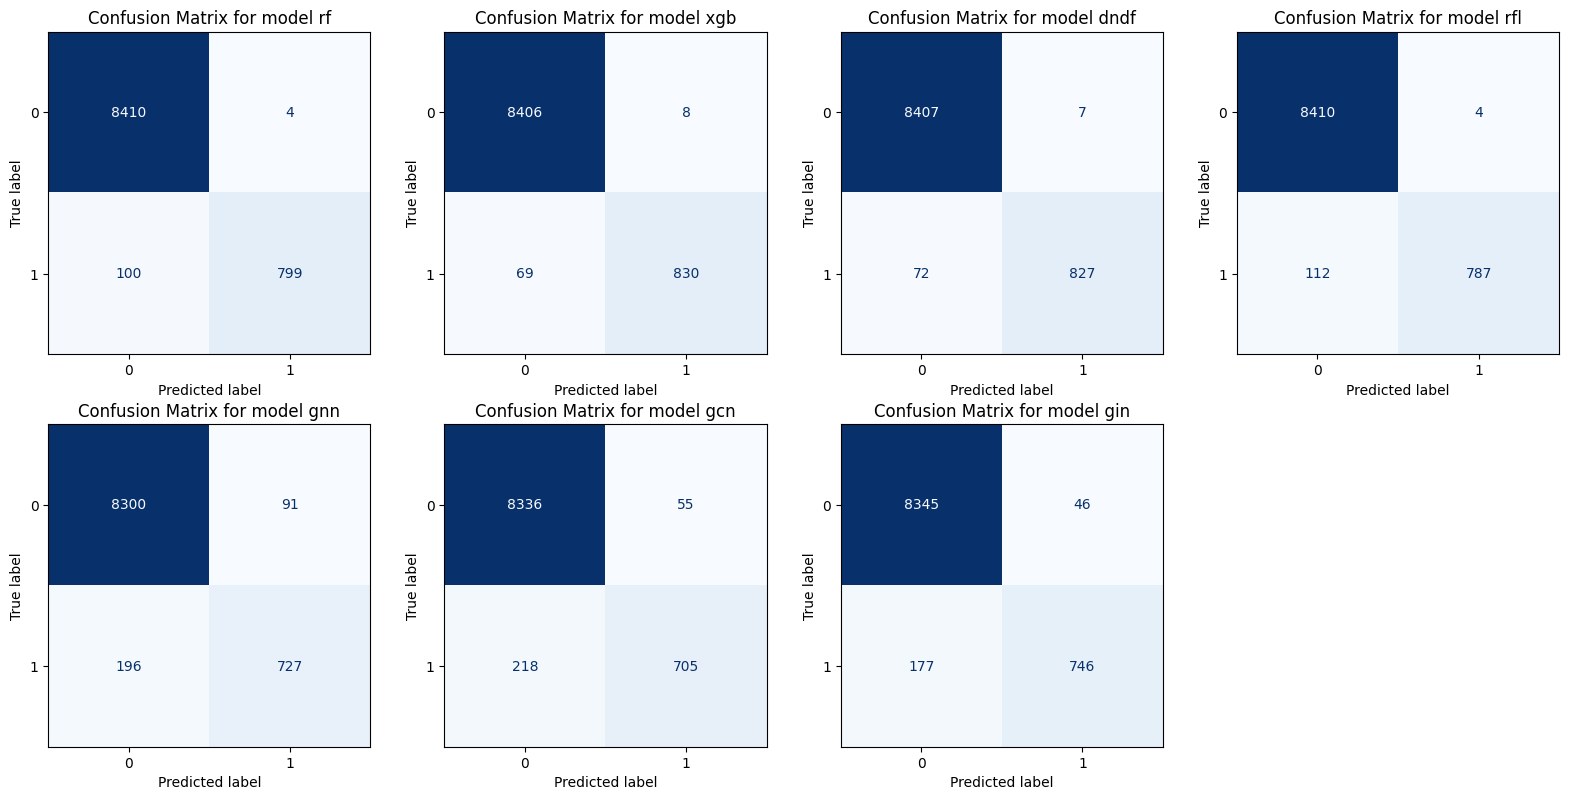

In [ ]:
cm_matrices = {
    "rf": rf_cm,
    "xgb": xgb_cm,
    "dndf": dndf_cm,
    "rfl": rfl_cm,
    "gnn": gnn_cm,
    "gcn": gcn_cm,
    "gin": gin_cm,
}

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for i, (label, cm) in enumerate(cm_matrices.items()):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=axes[i], cmap=plt.cm.Blues, colorbar=False)
    axes[i].set_title(f'Confusion Matrix for model {label}')

for j in range(7, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The confusion matrices indicate that all models are highly effective at predicting licit transactions (labeled as 0), with most having very few false positives, as evident from the strong diagonal in the top-left quadrant of each matrix. While the models also perform well at predicting illicit transactions (labeled as 1), there is some variability, with a higher number of false negatives (misclassifying illicit transactions as licit) compared to false positives. Overall, the results highlight that the models prioritize correctly classifying licit transactions while maintaining reasonable accuracy in detecting illicit ones.